/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

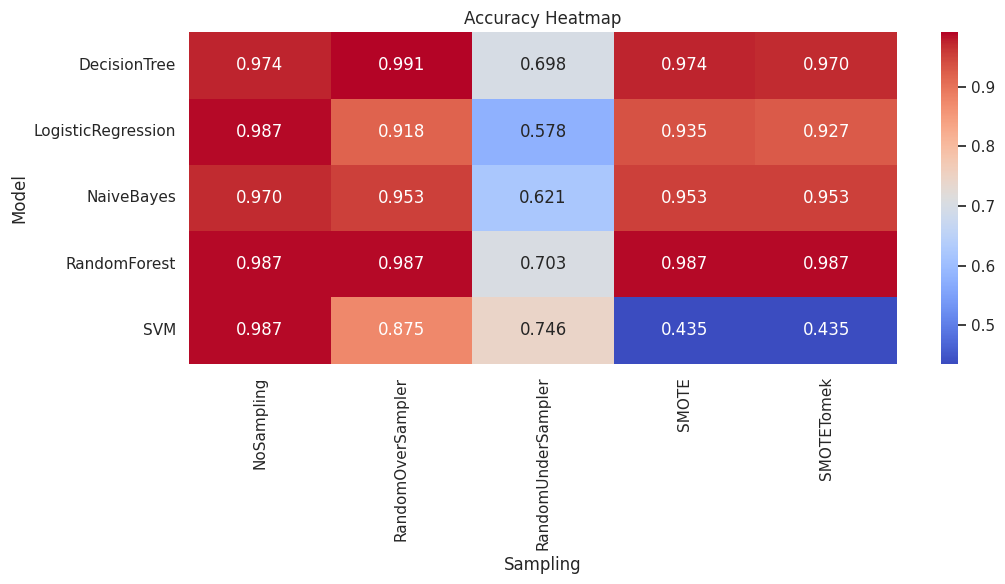

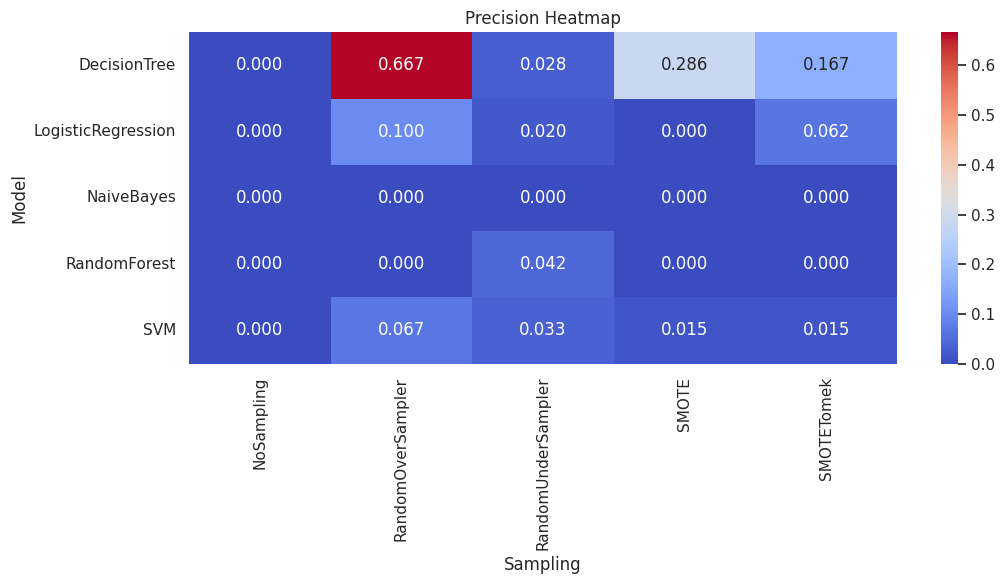

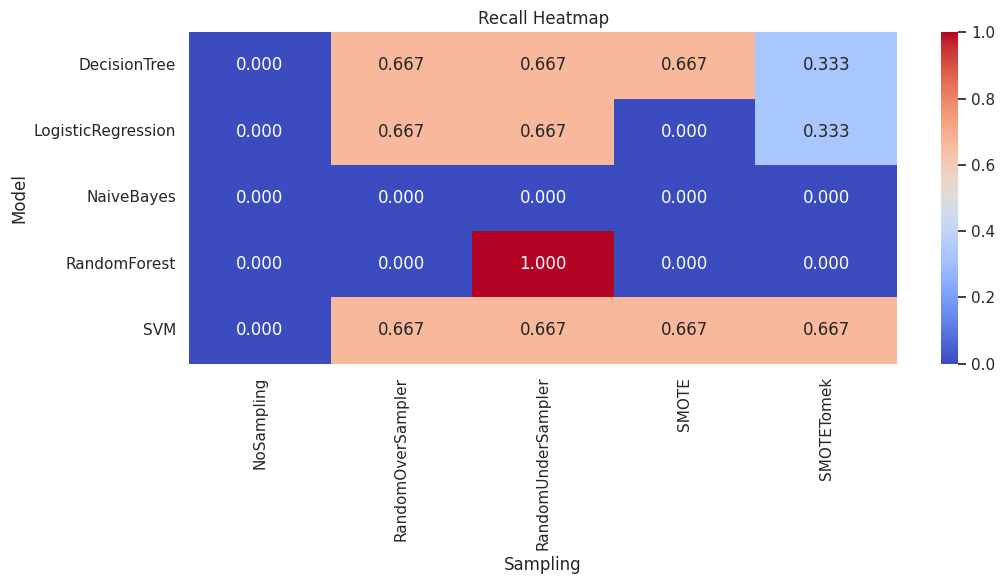

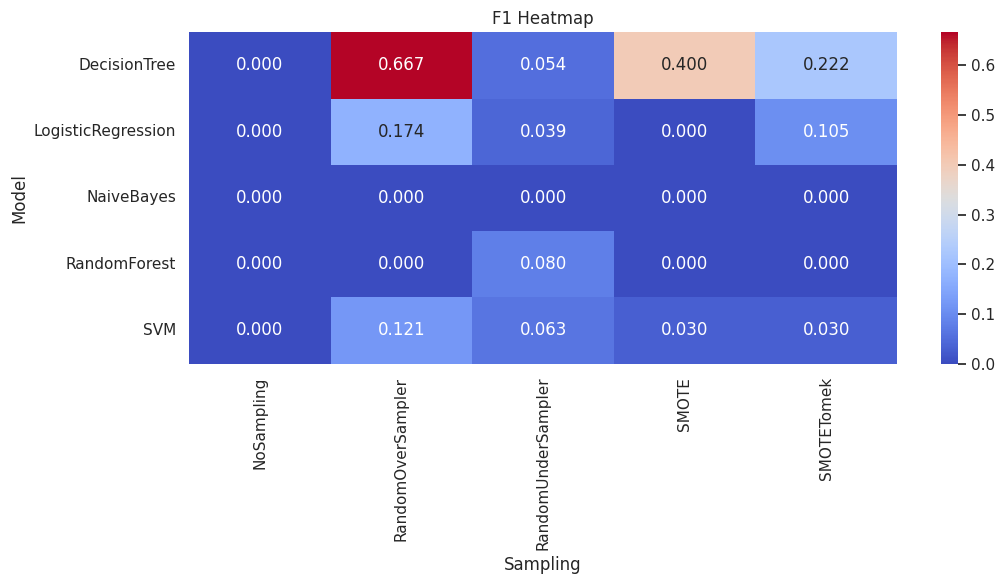

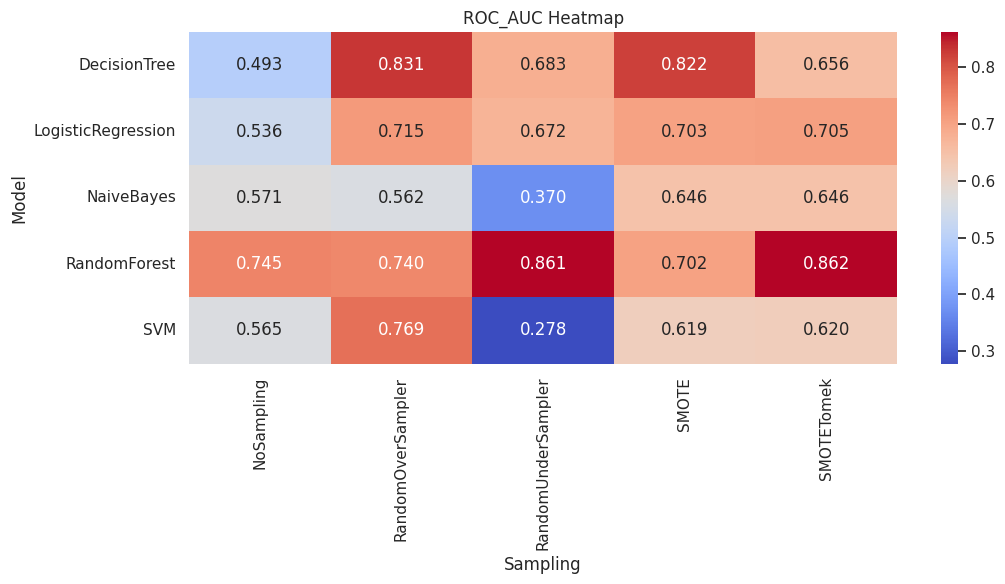

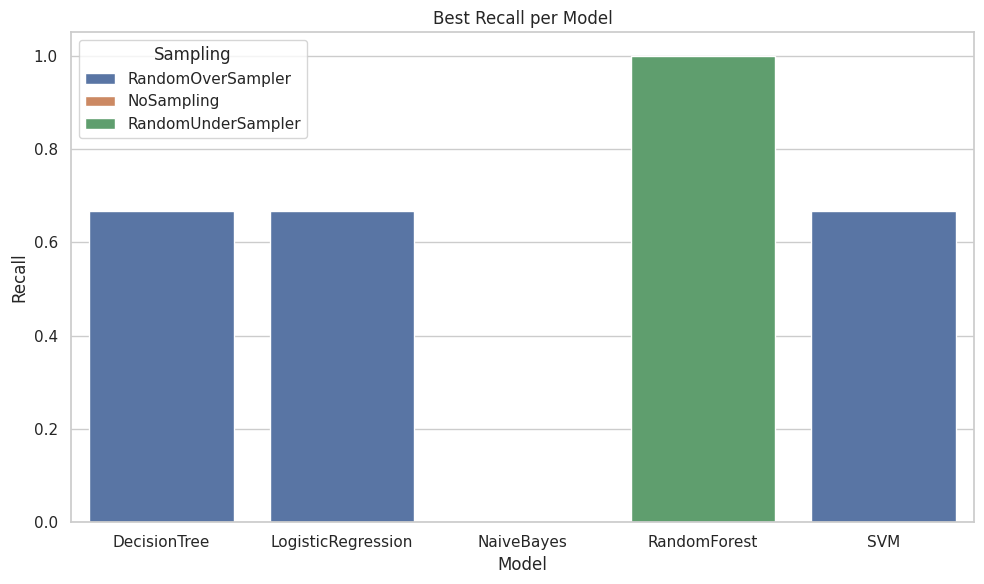

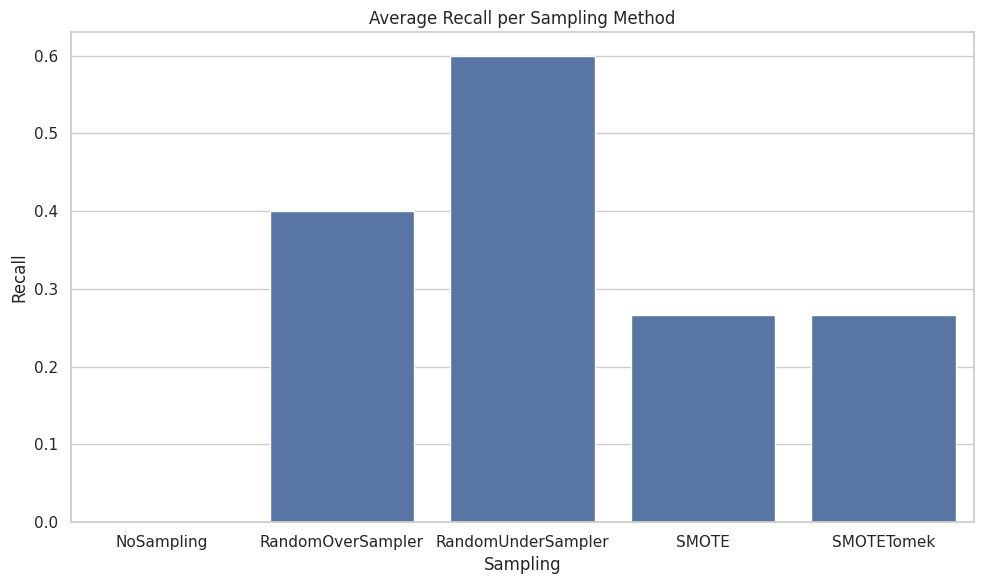

                 Model            Sampling  Accuracy  Precision    Recall  \
0   LogisticRegression          NoSampling  0.987069   0.000000  0.000000   
1   LogisticRegression   RandomOverSampler  0.918103   0.100000  0.666667   
2   LogisticRegression  RandomUnderSampler  0.577586   0.020202  0.666667   
3   LogisticRegression               SMOTE  0.935345   0.000000  0.000000   
4   LogisticRegression          SMOTETomek  0.926724   0.062500  0.333333   
5         DecisionTree          NoSampling  0.974138   0.000000  0.000000   
6         DecisionTree   RandomOverSampler  0.991379   0.666667  0.666667   
7         DecisionTree  RandomUnderSampler  0.698276   0.028169  0.666667   
8         DecisionTree               SMOTE  0.974138   0.285714  0.666667   
9         DecisionTree          SMOTETomek  0.969828   0.166667  0.333333   
10        RandomForest          NoSampling  0.987069   0.000000  0.000000   
11        RandomForest   RandomOverSampler  0.987069   0.000000  0.000000   

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

sns.set(style="whitegrid")

df = pd.read_csv("Creditcard_data.csv")

X = df.drop("Class", axis=1)
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

sampling_methods = {
    "NoSampling": None,
    "RandomOverSampler": RandomOverSampler(random_state=42),
    "RandomUnderSampler": RandomUnderSampler(random_state=42),
    "SMOTE": SMOTE(random_state=42),
    "SMOTETomek": SMOTETomek(random_state=42)
}

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(),
    "NaiveBayes": GaussianNB(),
    "SVM": SVC(probability=True)
}

records = []

for model_name, model in models.items():
    for sampling_name, sampler in sampling_methods.items():

        if sampler is not None:
            X_res, y_res = sampler.fit_resample(X_train, y_train)
        else:
            X_res, y_res = X_train, y_train

        model.fit(X_res, y_res)
        preds = model.predict(X_test)
        probs = model.predict_proba(X_test)[:,1]

        records.append([
            model_name,
            sampling_name,
            accuracy_score(y_test, preds),
            precision_score(y_test, preds),
            recall_score(y_test, preds),
            f1_score(y_test, preds),
            roc_auc_score(y_test, probs)
        ])

result_df = pd.DataFrame(
    records,
    columns=["Model", "Sampling", "Accuracy", "Precision", "Recall", "F1", "ROC_AUC"]
)

result_df.to_csv("full_metrics.csv", index=False)


metrics = ["Accuracy", "Precision", "Recall", "F1", "ROC_AUC"]

for metric in metrics:
    pivot = result_df.pivot(index="Model", columns="Sampling", values=metric)

    plt.figure(figsize=(11,6))
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap="coolwarm")
    plt.title(f"{metric} Heatmap")
    plt.tight_layout()
    plt.savefig(f"{metric.lower()}_heatmap.png")
    plt.show()
    plt.close()


best_models = result_df.loc[
    result_df.groupby("Model")["Recall"].idxmax()
]

best_models.to_csv("best_models_by_recall.csv", index=False)

plt.figure(figsize=(10,6))
sns.barplot(data=best_models, x="Model", y="Recall", hue="Sampling")
plt.title("Best Recall per Model")
plt.tight_layout()
plt.savefig("best_recall_per_model.png")
plt.show()
plt.close()


avg_sampling = result_df.groupby("Sampling")[metrics].mean().reset_index()
avg_sampling.to_csv("avg_metrics_per_sampling.csv", index=False)

plt.figure(figsize=(10,6))
sns.barplot(data=avg_sampling, x="Sampling", y="Recall")
plt.title("Average Recall per Sampling Method")
plt.tight_layout()
plt.savefig("avg_recall_sampling.png")
plt.show()
plt.close()

print(result_df)